In [1]:
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import time
import requests
from bs4 import BeautifulSoup
from PIL import Image
sns.set_theme(style="white")
sns.set(rc={'axes.facecolor':'#fbf9f4', 'figure.facecolor':'#fbf9f4',
           'axes.grid': False, 'axes.labelsize':8,
            'axes.edgecolor':'#fbf9f4', 'axes.labelcolor':'#4A2E19',
           'ytick.labelsize':8, 'xtick.labelsize':8,
           'ytick.labelcolor':'#4A2E19', 'xtick.labelcolor':'#4A2E19'})
matplotlib.rcParams['figure.dpi'] = 220

import warnings
warnings.filterwarnings("ignore")

In [2]:
date = 'As of 4/14/23'
signature = '@BeGriffis'
cG = 1.275
cxG = 1.536

In [3]:
def _parse_row(row):
    cols = None
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    return cols

URL = 'https://fbref.com/en/comps/Big5/Big-5-European-Leagues-Stats'
time.sleep(4)
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")
table = soup.find_all('table')[0]
data = []
headings=[]
headtext = soup.find_all("th",scope="col")
for i in range(len(headtext)):
    heading = headtext[i].get_text()
    headings.append(heading)
headings=headings[1:len(headings)]
data.append(headings)
table_body = table.find('tbody')
rows = table_body.find_all('tr')

for row_index in range(len(rows)):
    row = rows[row_index]
    cols = _parse_row(row)
    data.append(cols)

df = pd.DataFrame(data)
df = df.rename(columns=df.iloc[0])
df = df.reindex(df.index.drop(0))
df = df.replace('',0)

df.MP = df.MP.astype(int)
df.Pts = df.Pts.astype(int)
df.GF = df.GF.astype(int)
df.GA = df.GA.astype(int)
df.xG = df.xG.astype(float)
df.xGA = df.xGA.astype(float)

df['PythagPtsPct_GF'] = 0.0
df['PythagPtsPct_GF'] = (df['GF']**cG)/((df['GF']**cG)+(df['GA']**cG))
df['PythagPtsPct_xG'] = 0.0
df['PythagPtsPct_xG'] = (df['xG']**cxG)/((df['xG']**cxG)+(df['xGA']**cxG))
df['xPts_GF'] = (df['MP']*3) * df['PythagPtsPct_GF']
df['xPts_xG'] = (df['MP']*3) * df['PythagPtsPct_xG']
df['Pts-xPts_GF'] = df['Pts'] - df['xPts_GF']
df['Pts-xPts_xG'] = df['Pts'] - df['xPts_xG']

df = df[['Squad','MP','Pts','W','D','L','GF','GA','xG','xGA','xPts_GF','xPts_xG','Pts-xPts_GF','Pts-xPts_xG']]
df.sort_values(by=['Pts-xPts_xG'])


,Squad,MP,Pts,W,D,L,GF,GA,xG,xGA,xPts_GF,xPts_xG,Pts-xPts_GF,Pts-xPts_xG
97,Angers,30,14,3,5,22,23,64,33.8,48.2,19.201932,33.029685,-5.201932,-19.029685
94,Ajaccio,30,21,6,3,21,21,55,33.7,41.0,20.394415,38.274434,0.605585,-17.274434
88,Stuttgart,27,23,5,8,14,32,47,35.7,36.3,30.768995,39.981616,-7.768995,-16.981616
78,Valencia,28,27,7,6,15,30,34,36.7,34.7,38.655851,43.806417,-11.655851,-16.806417
42,Athletic Club,28,40,11,7,10,38,29,38.4,24.4,49.166240,56.063233,-9.166240,-16.063233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,Napoli,29,74,24,2,3,66,21,52.8,24.9,70.603924,66.149260,3.396076,7.850740
3,Arsenal,30,73,23,4,3,72,29,58.9,31.6,68.510901,65.016809,4.489099,7.983191
39,Lorient,30,45,12,9,9,42,40,35.5,46.0,46.399217,36.161562,-1.399217,8.838438
11,Lazio,30,61,18,7,5,49,20,39.3,33.0,68.232653,51.002238,-7.232653,9.997762


Text(0.5, 0.9, 'xG^1.275/(xG^1.275 + xGA^1.275)  |  Pearson r = 0.959')

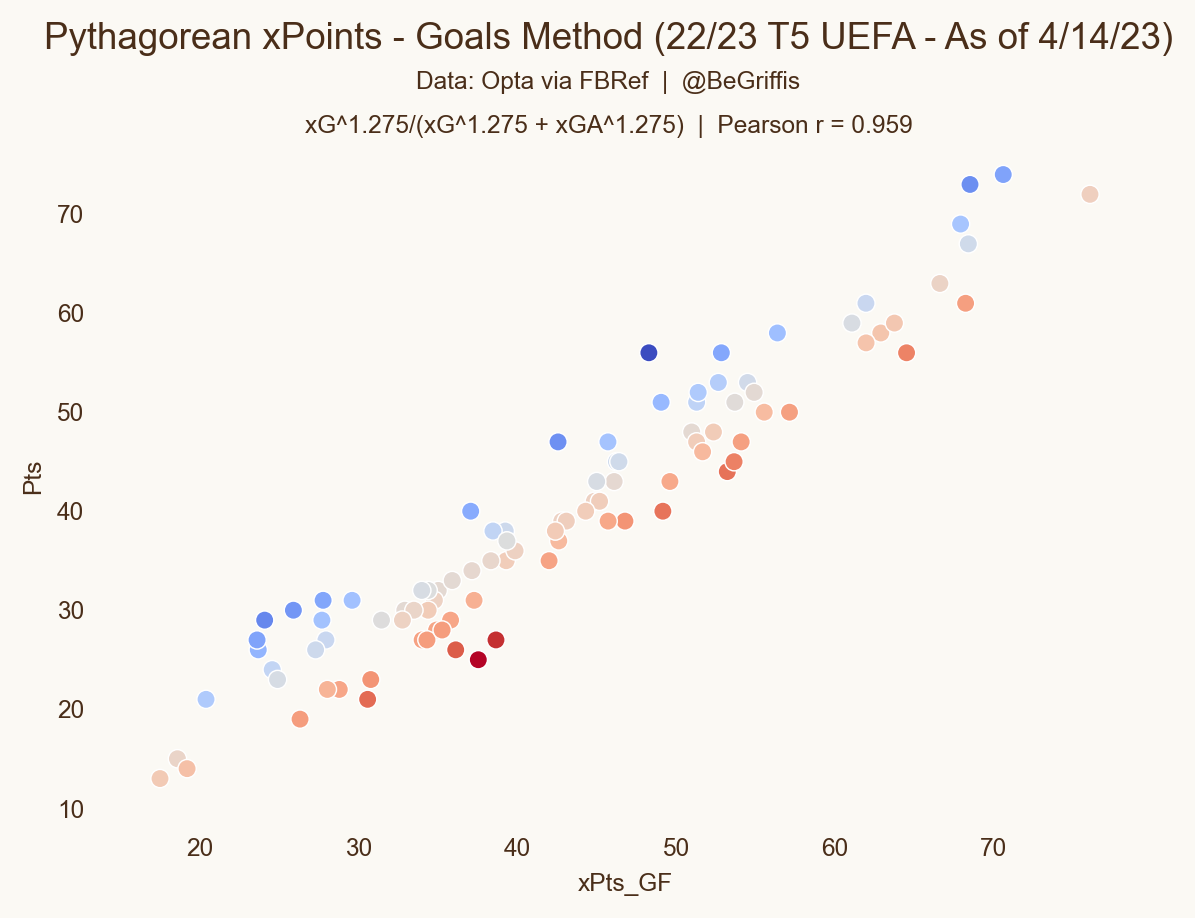

In [4]:
xx = df['xPts_GF']
yy = df['Pts']

ax = sns.scatterplot(x=xx, y=yy, c=yy-xx, cmap='coolwarm_r')

pr = scipy.stats.pearsonr(xx, yy)[0]

fig = plt.gcf()
fig.text(.5,1, 'Pythagorean xPoints - Goals Method (22/23 T5 UEFA - %s)' %date,
        ha='center', va='center', color='#4A2E19', size=12)
fig.text(.5,.95, 'Data: Opta via FBRef  |  %s' %signature,
        ha='center', va='center', color='#4A2E19', size=8)
fig.text(.5,.9, 'xG^%.3f/(xG^%.3f + xGA^%.3f)  |  Pearson r = %.3f' %(cG,cG,cG,pr),
        ha='center', va='center', color='#4A2E19', size=8)


Text(0.5, 0.9, 'xG^1.536/(xG^1.536 + xGA^1.536)  |  Pearson r = 0.867')

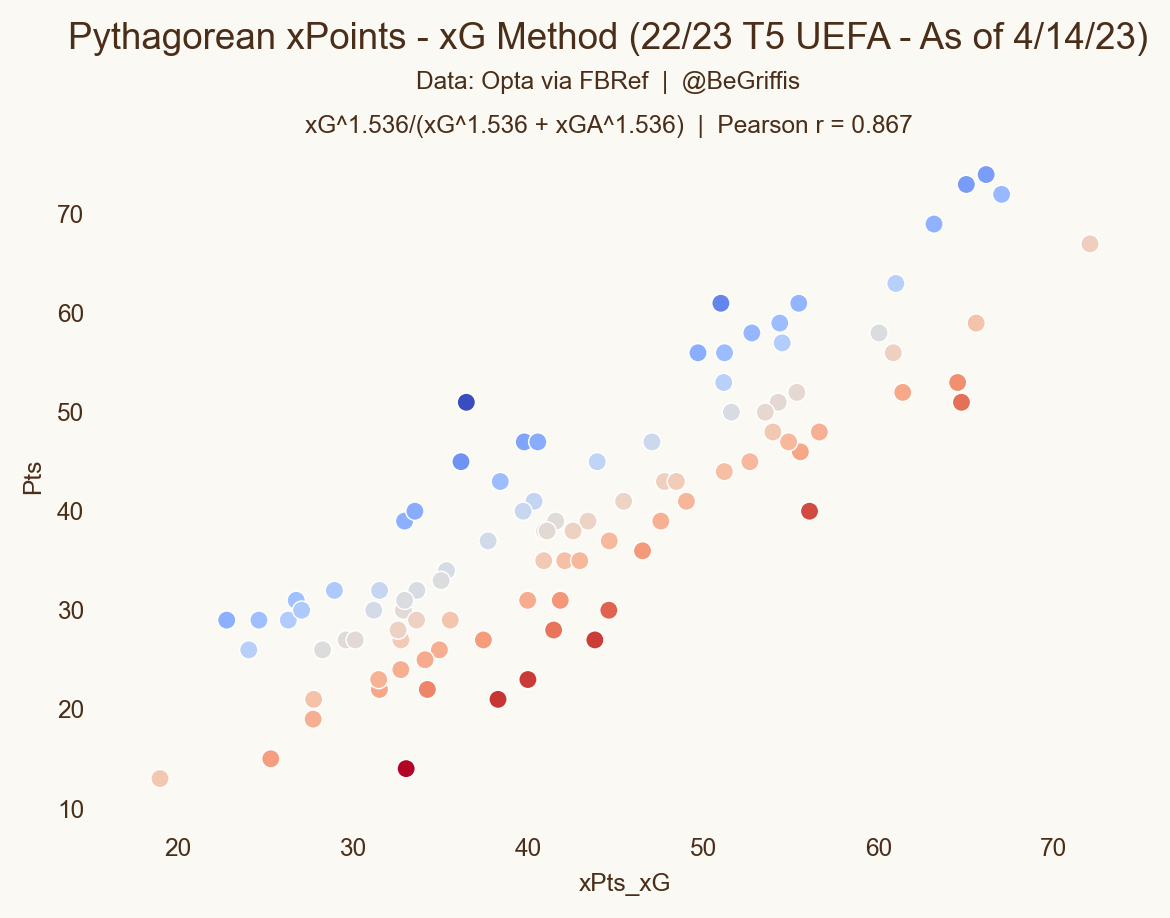

In [5]:
xx = df['xPts_xG']
yy = df['Pts']

ax = sns.scatterplot(x=xx, y=yy, c=yy-xx, cmap='coolwarm_r')

pr = scipy.stats.pearsonr(xx, yy)[0]

fig = plt.gcf()
fig.text(.5,1, 'Pythagorean xPoints - xG Method (22/23 T5 UEFA - %s)' %date,
        ha='center', va='center', color='#4A2E19', size=12)
fig.text(.5,.95, 'Data: Opta via FBRef  |  %s' %signature,
        ha='center', va='center', color='#4A2E19', size=8)
fig.text(.5,.9, 'xG^%.3f/(xG^%.3f + xGA^%.3f)  |  Pearson r = %.3f' %(cxG,cxG,cxG,pr),
        ha='center', va='center', color='#4A2E19', size=8)


In [6]:
def ax_logo(team, ax,):
    path = 'ENTER YOUR/IMAGE FILE PATH/HERE'
    club_icon = Image.open('%s/%s.png' %(path,team))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

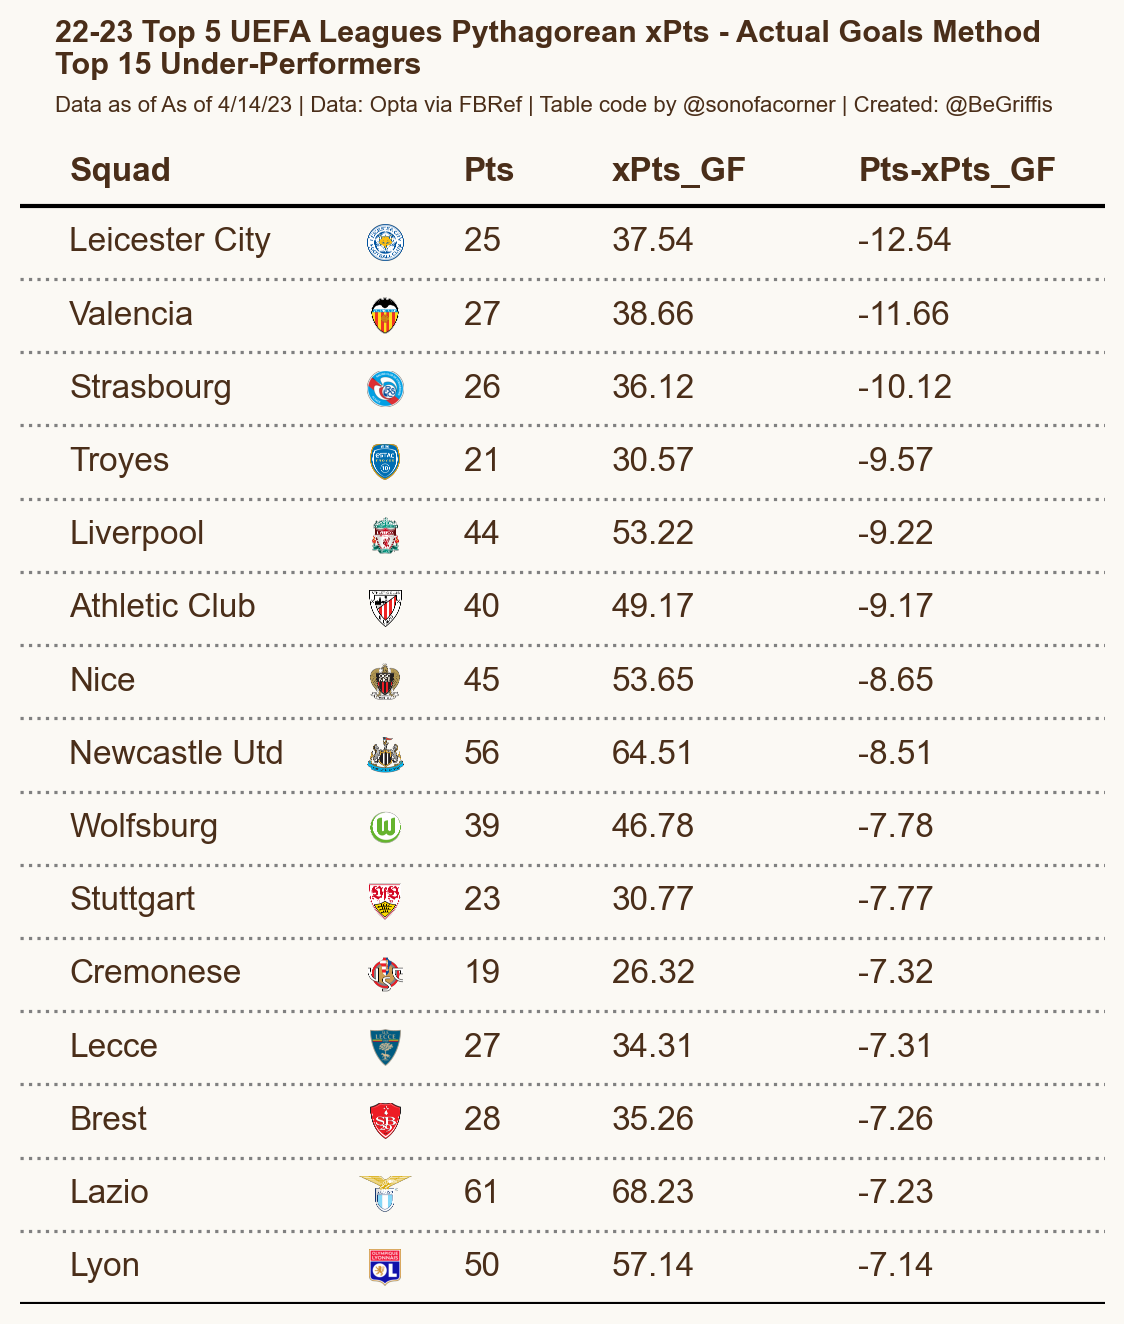

In [7]:
indexdf = df.sort_values(by=['Pts-xPts_GF'],ascending=True).head(15)[['Squad','Pts','xPts_GF','Pts-xPts_GF']].reset_index(drop=True)
indexdf_short=indexdf[::-1]

fig = plt.figure(figsize=(7,8), dpi=200)
ax = plt.subplot()

ncols = len(indexdf_short.columns.tolist())+1
nrows = indexdf_short.shape[0]

ax.set_xlim(0, ncols + .5)
ax.set_ylim(0, nrows + 1.5)

# lgs = ['J1', 'J2', 'Ekstraklasa', 'J3']
# if lg in lgs:
positions = [0.25, 2.25, 3, 4.25]
# else:
#     positions = [0.25, 2.25, 3.75, 4.5, 5.25]
columns = indexdf_short.columns.tolist()

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if 'xPts' in column:
            text_label = f'{indexdf_short[column].iloc[i]:,.2f}'
            weight = 'regular'
        else:
            text_label = f'{indexdf_short[column].iloc[i]}'
            weight = 'regular'
        ax.annotate(
            xy=(positions[j], i + .5),
            text = text_label,
            ha='left',
            va='center', color='#4A2E19',
            weight=weight
        )

# Add column names
column_names = columns
for index, c in enumerate(column_names):
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha='left',
            va='bottom',
            weight='bold', color='#4A2E19'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.set_axis_off()

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.6, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(indexdf_short['Squad'].iloc[x], flag_ax,)

fig.text(
    x=0.15, y=.89,
    s='22-23 Top 5 UEFA Leagues Pythagorean xPts - Actual Goals Method\nTop 15 Under-Performers',
    ha='left',
    va='bottom',
    weight='bold',
    size=11, color='#4A2E19'
)
fig.text(
    x=0.15, y=.88,
    s='Data as of %s | Data: Opta via FBRef | Table code by @sonofacorner | Created: %s' %(date,signature),
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

plt.savefig(
    'Pythag xPts GF Underperformers T5.png',
    dpi=300,
    transparent=False,
    bbox_inches='tight'
)

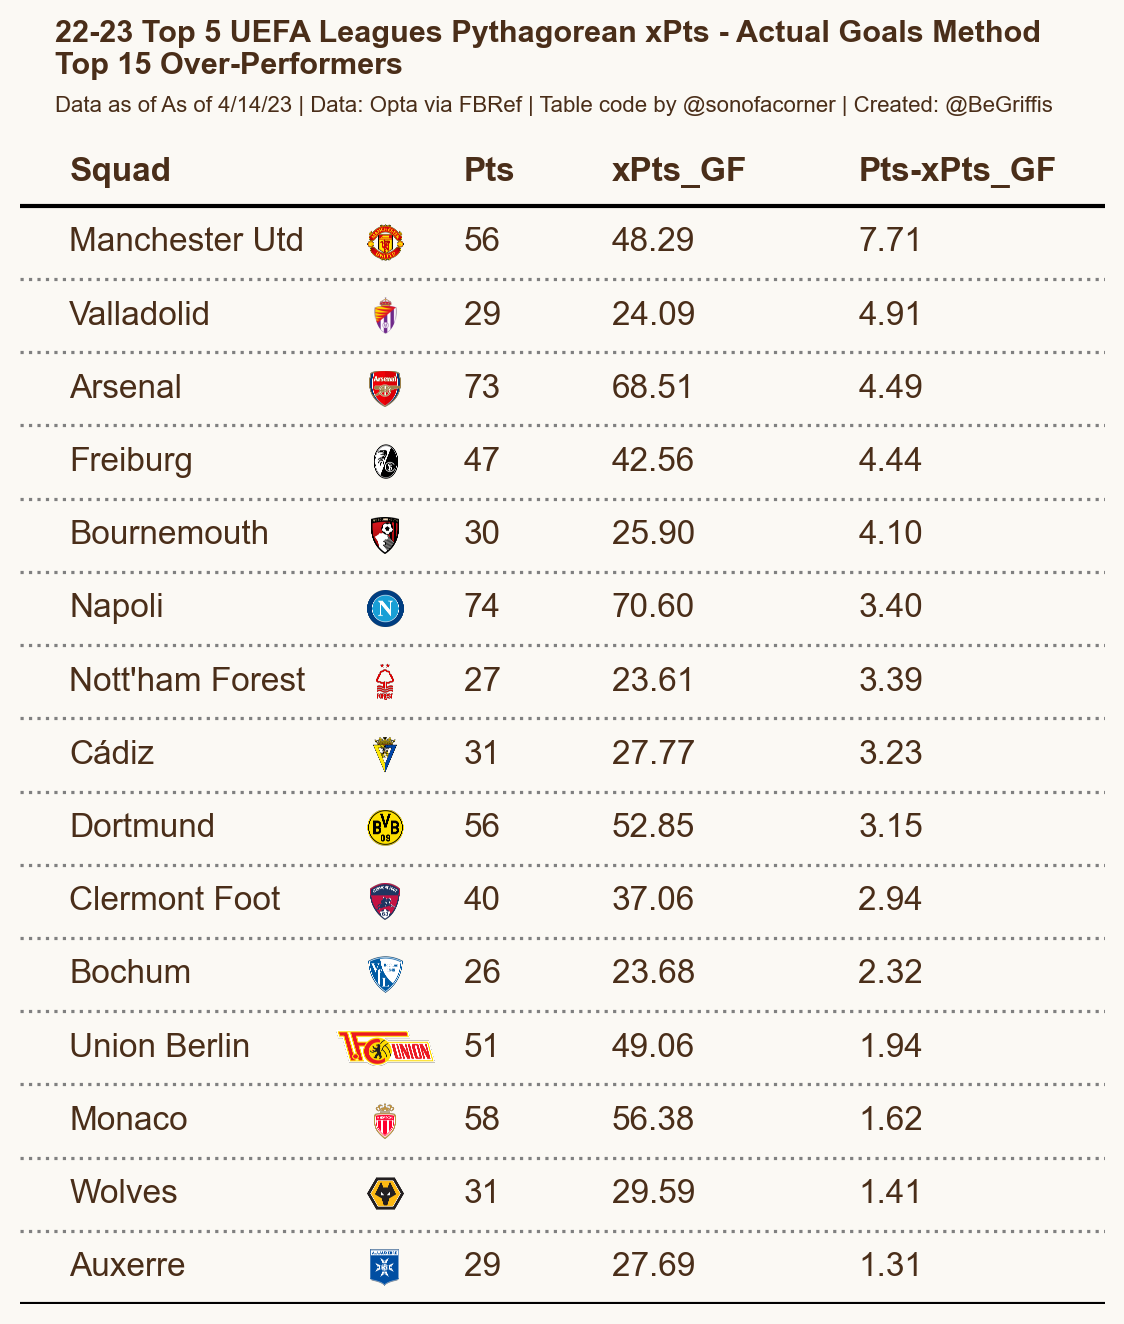

In [8]:
indexdf = df.sort_values(by=['Pts-xPts_GF'],ascending=False).head(15)[['Squad','Pts','xPts_GF','Pts-xPts_GF']].reset_index(drop=True)
indexdf_short=indexdf[::-1]

fig = plt.figure(figsize=(7,8), dpi=200)
ax = plt.subplot()

ncols = len(indexdf_short.columns.tolist())+1
nrows = indexdf_short.shape[0]

ax.set_xlim(0, ncols + .5)
ax.set_ylim(0, nrows + 1.5)

# lgs = ['J1', 'J2', 'Ekstraklasa', 'J3']
# if lg in lgs:
positions = [0.25, 2.25, 3, 4.25]
# else:
#     positions = [0.25, 2.25, 3.75, 4.5, 5.25]
columns = indexdf_short.columns.tolist()

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if 'xPts' in column:
            text_label = f'{indexdf_short[column].iloc[i]:,.2f}'
            weight = 'regular'
        else:
            text_label = f'{indexdf_short[column].iloc[i]}'
            weight = 'regular'
        ax.annotate(
            xy=(positions[j], i + .5),
            text = text_label,
            ha='left',
            va='center', color='#4A2E19',
            weight=weight
        )

# Add column names
column_names = columns
for index, c in enumerate(column_names):
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha='left',
            va='bottom',
            weight='bold', color='#4A2E19'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.set_axis_off()

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.6, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(indexdf_short['Squad'].iloc[x], flag_ax,)

fig.text(
    x=0.15, y=.89,
    s='22-23 Top 5 UEFA Leagues Pythagorean xPts - Actual Goals Method\nTop 15 Over-Performers',
    ha='left',
    va='bottom',
    weight='bold',
    size=11, color='#4A2E19'
)
fig.text(
    x=0.15, y=.88,
    s='Data as of %s | Data: Opta via FBRef | Table code by @sonofacorner | Created: %s' %(date,signature),
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

plt.savefig(
    'Pythag xPts GF Overperformers T5.png',
    dpi=300,
    transparent=False,
    bbox_inches='tight'
)

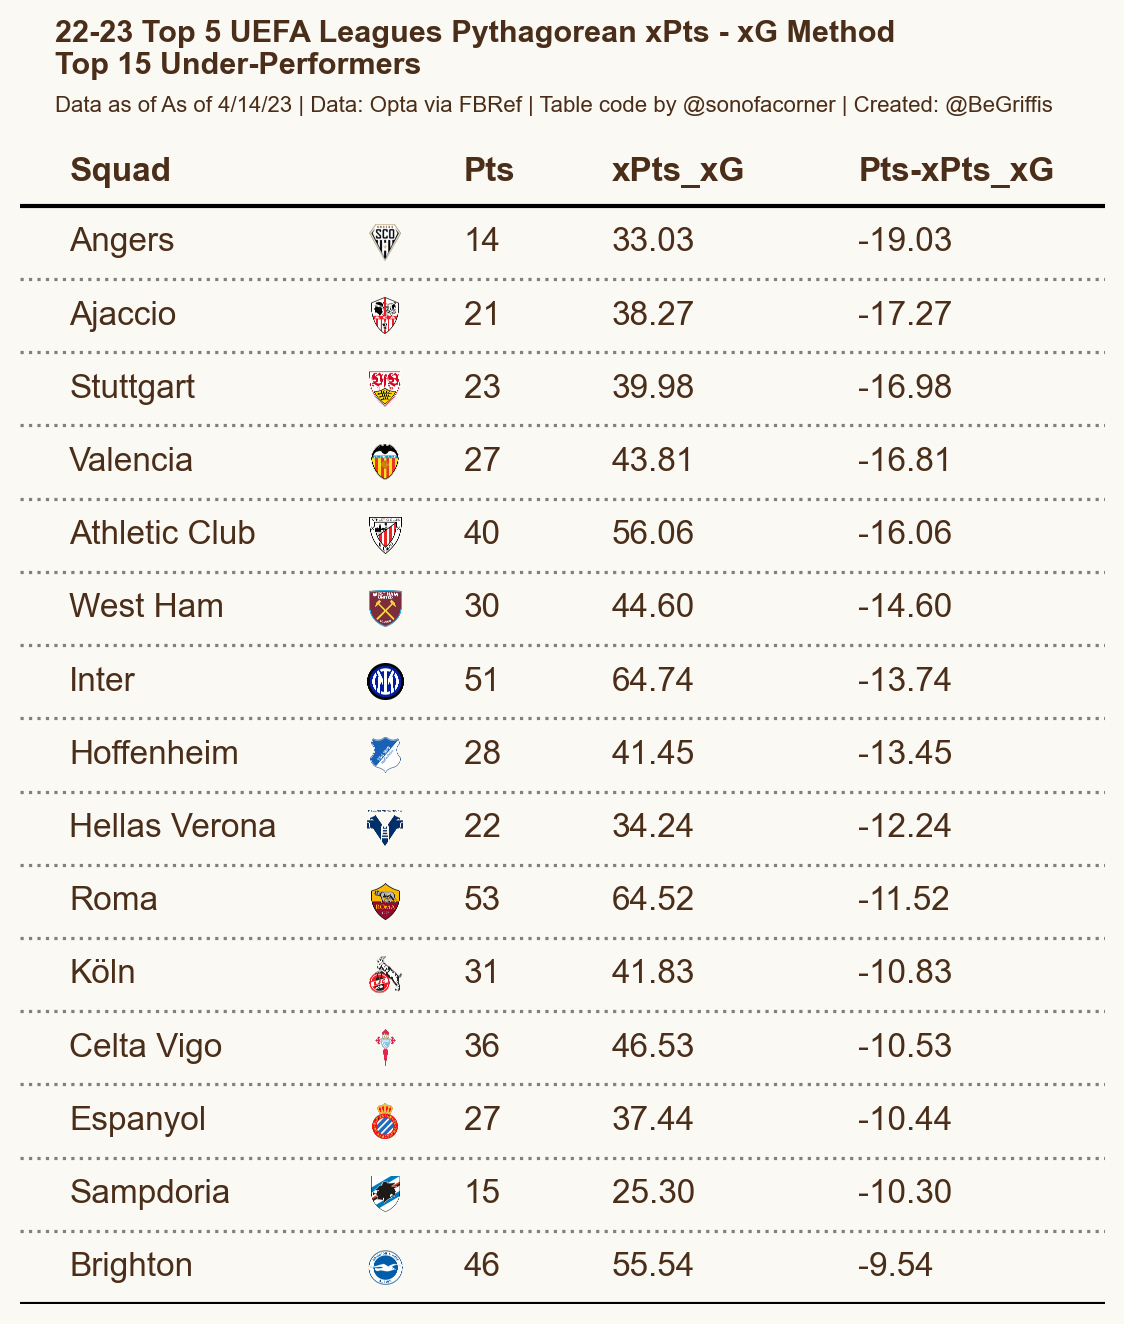

In [9]:
indexdf = df.sort_values(by=['Pts-xPts_xG'],ascending=True).head(15)[['Squad','Pts','xPts_xG','Pts-xPts_xG']].reset_index(drop=True)
indexdf_short=indexdf[::-1]

fig = plt.figure(figsize=(7,8), dpi=200)
ax = plt.subplot()

ncols = len(indexdf_short.columns.tolist())+1
nrows = indexdf_short.shape[0]

ax.set_xlim(0, ncols + .5)
ax.set_ylim(0, nrows + 1.5)

# lgs = ['J1', 'J2', 'Ekstraklasa', 'J3']
# if lg in lgs:
positions = [0.25, 2.25, 3, 4.25]
# else:
#     positions = [0.25, 2.25, 3.75, 4.5, 5.25]
columns = indexdf_short.columns.tolist()

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if 'xPts' in column:
            text_label = f'{indexdf_short[column].iloc[i]:,.2f}'
            weight = 'regular'
        else:
            text_label = f'{indexdf_short[column].iloc[i]}'
            weight = 'regular'
        ax.annotate(
            xy=(positions[j], i + .5),
            text = text_label,
            ha='left',
            va='center', color='#4A2E19',
            weight=weight
        )

# Add column names
column_names = columns
for index, c in enumerate(column_names):
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha='left',
            va='bottom',
            weight='bold', color='#4A2E19'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.set_axis_off()

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.6, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(indexdf_short['Squad'].iloc[x], flag_ax,)

fig.text(
    x=0.15, y=.89,
    s='22-23 Top 5 UEFA Leagues Pythagorean xPts - xG Method\nTop 15 Under-Performers',
    ha='left',
    va='bottom',
    weight='bold',
    size=11, color='#4A2E19'
)
fig.text(
    x=0.15, y=.88,
    s='Data as of %s | Data: Opta via FBRef | Table code by @sonofacorner | Created: %s' %(date,signature),
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

plt.savefig(
    'Pythag xPts xG Underperformers T5.png',
    dpi=300,
    transparent=False,
    bbox_inches='tight'
)

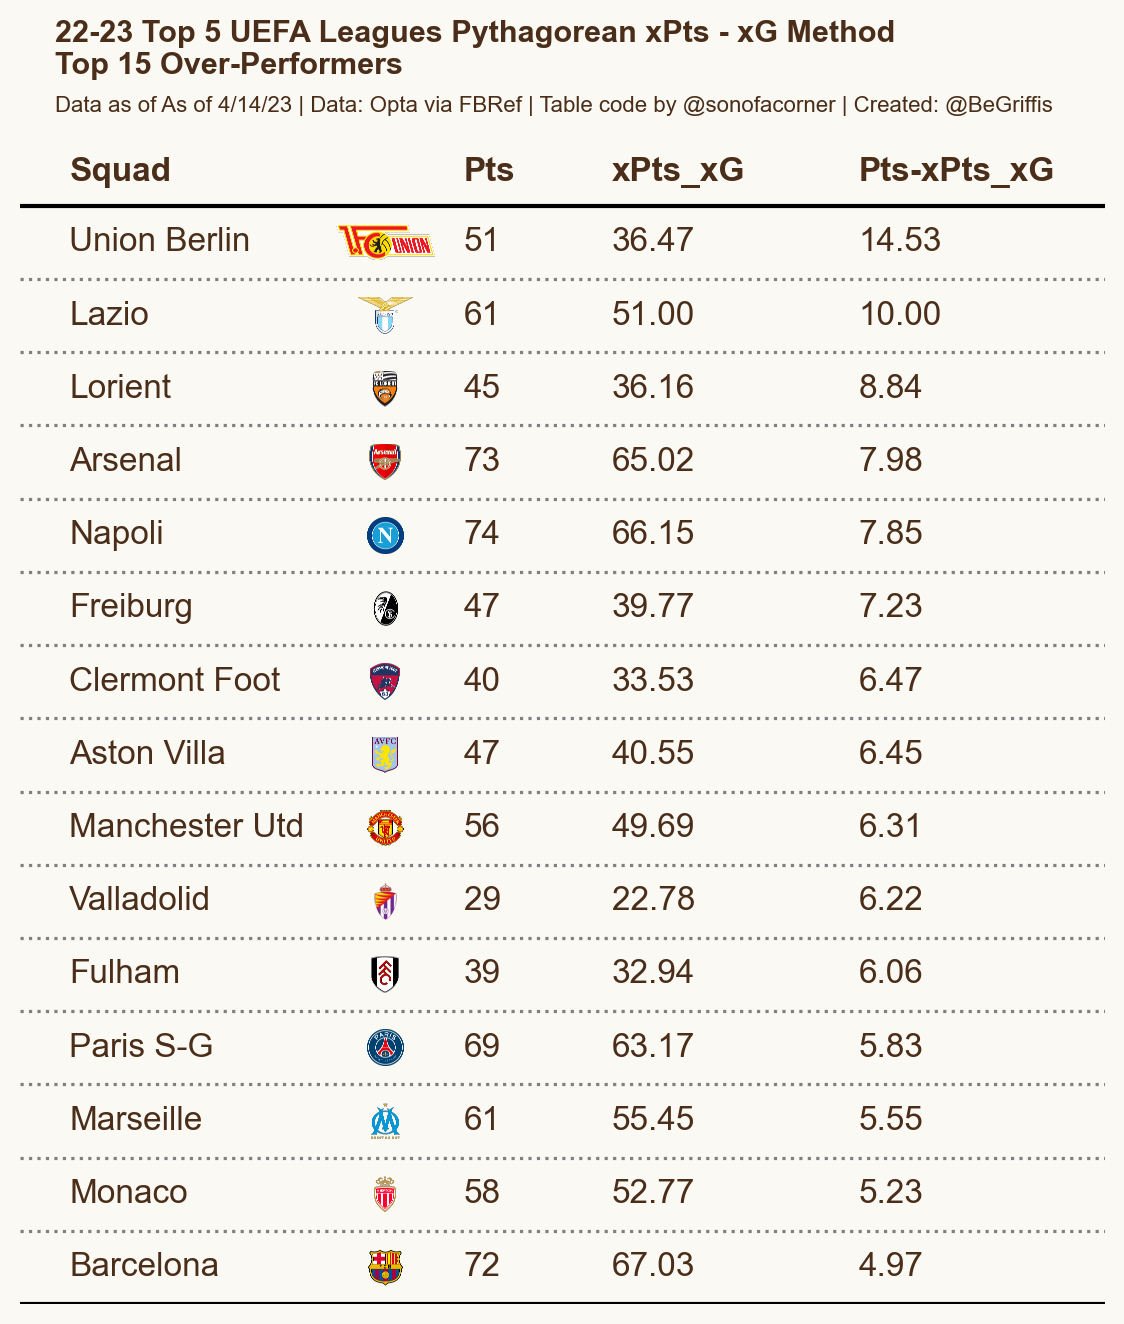

In [10]:
indexdf = df.sort_values(by=['Pts-xPts_xG'],ascending=False).head(15)[['Squad','Pts','xPts_xG','Pts-xPts_xG']].reset_index(drop=True)
indexdf_short=indexdf[::-1]

fig = plt.figure(figsize=(7,8), dpi=200)
ax = plt.subplot()

ncols = len(indexdf_short.columns.tolist())+1
nrows = indexdf_short.shape[0]

ax.set_xlim(0, ncols + .5)
ax.set_ylim(0, nrows + 1.5)

# lgs = ['J1', 'J2', 'Ekstraklasa', 'J3']
# if lg in lgs:
positions = [0.25, 2.25, 3, 4.25]
# else:
#     positions = [0.25, 2.25, 3.75, 4.5, 5.25]
columns = indexdf_short.columns.tolist()

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if 'xPts' in column:
            text_label = f'{indexdf_short[column].iloc[i]:,.2f}'
            weight = 'regular'
        else:
            text_label = f'{indexdf_short[column].iloc[i]}'
            weight = 'regular'
        ax.annotate(
            xy=(positions[j], i + .5),
            text = text_label,
            ha='left',
            va='center', color='#4A2E19',
            weight=weight
        )

# Add column names
column_names = columns
for index, c in enumerate(column_names):
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha='left',
            va='bottom',
            weight='bold', color='#4A2E19'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.set_axis_off()

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.6, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(indexdf_short['Squad'].iloc[x], flag_ax,)

fig.text(
    x=0.15, y=.89,
    s='22-23 Top 5 UEFA Leagues Pythagorean xPts - xG Method\nTop 15 Over-Performers',
    ha='left',
    va='bottom',
    weight='bold',
    size=11, color='#4A2E19'
)
fig.text(
    x=0.15, y=.88,
    s='Data as of %s | Data: Opta via FBRef | Table code by @sonofacorner | Created: %s' %(date,signature),
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

plt.savefig(
    'Pythag xPts xG Overperformers T5.png',
    dpi=300,
    transparent=False,
    bbox_inches='tight'
)